In [283]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [284]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [325]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [327]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [341]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )

sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [342]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

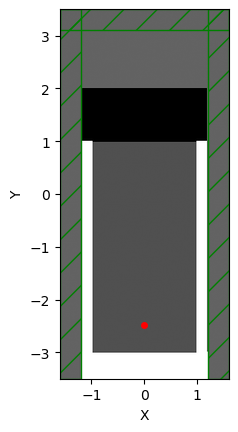

In [343]:
monitor_position_J, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position_J,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(False)

In [344]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [345]:
eta_i = 0.5

def mapping(x, beta, eta_i):
    projected_field = mpa.tanh_projection(x, beta, eta_i)
    return projected_field.flatten()

In [ ]:
cur_iter = [0]
binary_history = []
evaluation_history = []
binarization_history = []
beta_history = []

full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)

def f (v, gradient, beta):
    binarization_degree = np.sum(np.abs(v-0.5))*2 / (v.size)
    binarization_history.append(binarization_degree)

    print("Current iteration: {}".format(cur_iter[0] + 1))
    print("Current beta: {}".format(beta))

    rho_vector = mapping(v, beta, eta_i)

    f0, dJ_du = opt([rho_vector])

    f = np.array([np.real(f0)])

    ###########################################
    plt.figure(figsize = (4,2))
    ax = plt.gca()
    opt.plot2D(
        False,

        output_plane = mp.Volume(size = mp.Vector3(2.4, 1, 0), center = mp.Vector3(0, full_center_y,0)),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )

    ax.axis("off")
    plt.show()
    ###########################################
    
    if v.size > 0:
        gradient = v*0
        
        # dJ = np.sum(dJ_du[0])
        gradient = tensor_jacobian_product(mapping,0)(
            v, eta_i, beta, dJ_du
        )

        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)

        # beta= beta+ npa.tanh((beta-0.5)*0.01)

        beta_multiplier = 1.005  # 1 + 0.5%

        beta = beta * beta_multiplier

        evaluation_history.append(f)
        beta_history.append(beta)
        cur_iter[0] = cur_iter[0] + 1
        # lr_history.append(adam_lr)
        # uf_history.append(adam_uf)
        # t_history.append(adam_t
    print('f=', f, 'dJ=',dJ_du)

    return updated_x, adam_m, adam_v, beta

Current iteration: 1
Current beta: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


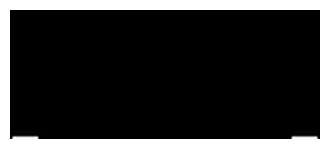

f= [0.00086994] dJ= [ 1.79446681e-04  1.94860207e-04  1.91875752e-04 ... -4.34669501e-05
 -5.37955394e-05 -1.08627222e-04]
  → Bi_idx = 0.000
Current iteration: 2
Current beta: 2.1
Starting forward run...
Starting adjoint run...
Calculating gradient...


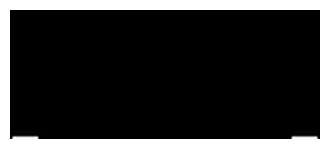

f= [0.001016] dJ= [ 1.88318684e-04  2.02798408e-04  1.94293330e-04 ... -4.52961330e-05
 -5.33904802e-05 -9.33172767e-05]
  → Bi_idx = 0.000
Current iteration: 3
Current beta: 2.205
Starting forward run...
Starting adjoint run...
Calculating gradient...


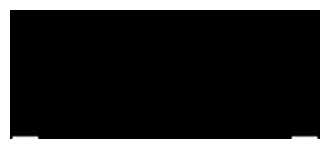

f= [0.00129693] dJ= [ 1.93648626e-04  2.04468276e-04  1.85278359e-04 ... -4.84992195e-05
 -5.10291722e-05 -6.69225216e-05]
  → Bi_idx = 0.000
Current iteration: 4
Current beta: 2.3152500000000003
Starting forward run...
Starting adjoint run...
Calculating gradient...


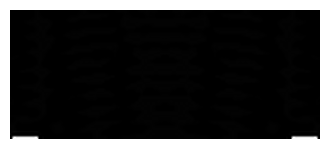

f= [0.00169375] dJ= [ 1.81256715e-04  1.86289519e-04  1.56444985e-04 ... -4.98091283e-05
 -4.01412570e-05 -2.80399061e-05]
  → Bi_idx = 0.000
Current iteration: 5
Current beta: 2.4310125000000005
Starting forward run...
Starting adjoint run...
Calculating gradient...


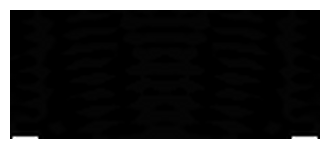

f= [0.00223625] dJ= [ 1.50673180e-04  1.50924849e-04  1.16246030e-04 ... -4.39335719e-05
 -1.33711478e-05  3.11089518e-05]
  → Bi_idx = 0.000
Current iteration: 6
Current beta: 2.5525631250000007
Starting forward run...
Starting adjoint run...
Calculating gradient...


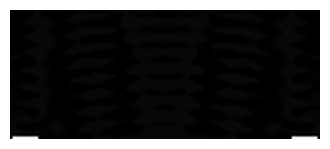

f= [0.00299583] dJ= [ 1.17007410e-04  1.19584361e-04  9.09789121e-05 ... -2.46323168e-05
  3.71573487e-05  1.22855880e-04]
  → Bi_idx = 0.000
Current iteration: 7
Current beta: 2.680191281250001
Starting forward run...
Starting adjoint run...
Calculating gradient...


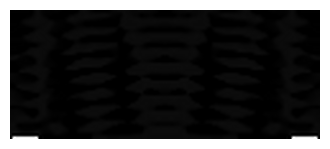

f= [0.00410625] dJ= [9.83084903e-05 1.11557556e-04 9.78687080e-05 ... 3.02535838e-06
 1.08672204e-04 2.52137148e-04]
  → Bi_idx = 0.000
Current iteration: 8
Current beta: 2.814200845312501
Starting forward run...
Starting adjoint run...
Calculating gradient...


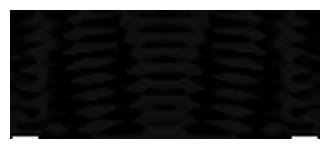

f= [0.00591831] dJ= [8.56028386e-05 1.05447508e-04 9.99960884e-05 ... 4.61387476e-06
 1.68865979e-04 3.99070845e-04]
  → Bi_idx = 0.000
Current iteration: 9
Current beta: 2.954910887578126
Starting forward run...
Starting adjoint run...
Calculating gradient...


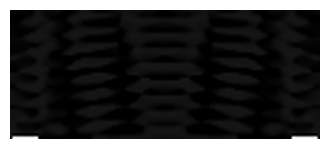

f= [0.00881486] dJ= [ 4.74736405e-05  5.90745796e-05  4.66614920e-05 ... -7.75695785e-05
  1.35250693e-04  4.58675879e-04]
  → Bi_idx = 0.000
Current iteration: 10
Current beta: 3.1026564319570324
Starting forward run...
Starting adjoint run...
Calculating gradient...


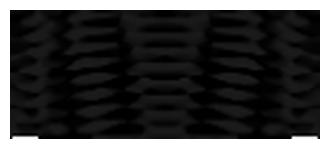

f= [0.01220802] dJ= [ 1.21241621e-05  1.16333545e-05 -1.85310085e-06 ... -2.66247787e-04
 -8.15658483e-05  2.44075175e-04]
  → Bi_idx = 0.000
Current iteration: 11
Current beta: 3.257789253554884
Starting forward run...
Starting adjoint run...
Calculating gradient...


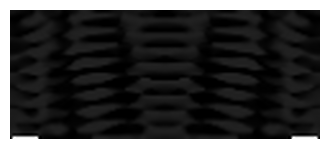

f= [0.01457812] dJ= [-1.98797684e-05 -4.69222913e-05 -7.49911824e-05 ... -5.29885575e-04
 -3.68486826e-04 -4.18824202e-05]
  → Bi_idx = 0.000
Current iteration: 12
Current beta: 3.4206787162326284
Starting forward run...
Starting adjoint run...
Calculating gradient...


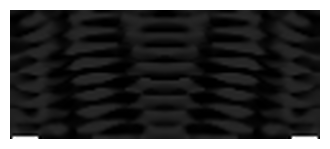

f= [0.01504831] dJ= [ 0.00011186  0.00011989  0.00011675 ... -0.00091577 -0.00065436
 -0.00018878]
  → Bi_idx = 0.000
Current iteration: 13
Current beta: 3.59171265204426
Starting forward run...
Starting adjoint run...
Calculating gradient...


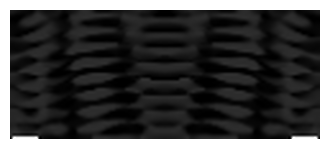

f= [0.01616935] dJ= [-7.45281161e-05 -2.02649756e-04 -3.45043824e-04 ... -6.33556307e-04
 -2.31432617e-04  4.73718963e-04]
  → Bi_idx = 0.000
Current iteration: 14
Current beta: 3.7712982846464733
Starting forward run...
Starting adjoint run...
Calculating gradient...


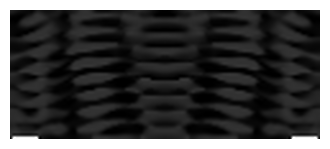

f= [0.01826082] dJ= [-0.00019631 -0.00038891 -0.00059488 ...  0.00016413  0.00057856
  0.00132237]
  → Bi_idx = 0.000
Current iteration: 15
Current beta: 3.9598631988787973
Starting forward run...
Starting adjoint run...
Calculating gradient...


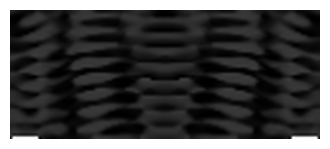

f= [0.02018406] dJ= [ 3.16217468e-05 -6.40830194e-05 -1.75905900e-04 ...  4.26812722e-04
  7.79261940e-04  1.34381068e-03]
  → Bi_idx = 0.000
Current iteration: 16
Current beta: 4.1578563588227375
Starting forward run...
Starting adjoint run...
Calculating gradient...


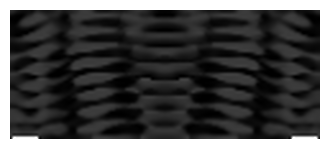

f= [0.02106875] dJ= [9.13565047e-05 7.09981993e-05 5.16716570e-05 ... 6.11267332e-04
 8.75153364e-04 1.21488806e-03]
  → Bi_idx = 0.000
Current iteration: 17
Current beta: 4.365749176763875
Starting forward run...
Starting adjoint run...
Calculating gradient...


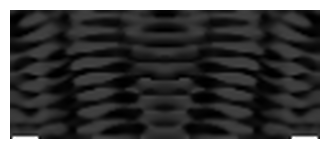

f= [0.0206531] dJ= [5.48149188e-05 9.03665542e-05 1.28681224e-04 ... 7.38028321e-04
 7.69895374e-04 7.29095826e-04]
  → Bi_idx = 0.000
Current iteration: 18
Current beta: 4.584036635602069
Starting forward run...
Starting adjoint run...
Calculating gradient...


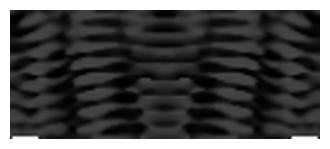

f= [0.01693443] dJ= [-6.51979399e-05 -7.28309751e-05 -8.94646290e-05 ...  1.26366750e-03
  8.27925361e-04  9.70084270e-05]
  → Bi_idx = 0.000
Current iteration: 19
Current beta: 4.813238467382172
Starting forward run...
Starting adjoint run...
Calculating gradient...


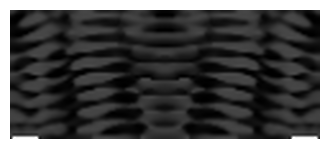

f= [0.02170926] dJ= [2.93430597e-05 5.04881991e-05 6.20678210e-05 ... 1.32173949e-03
 1.09378745e-03 7.75679610e-04]
  → Bi_idx = 0.000
Current iteration: 20
Current beta: 5.053900390751281
Starting forward run...
Starting adjoint run...
Calculating gradient...


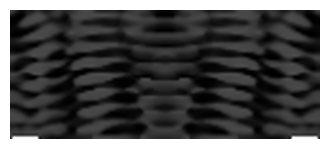

f= [0.0229706] dJ= [3.59723261e-05 3.56455743e-05 2.59184643e-05 ... 2.21435468e-03
 1.90924895e-03 1.60009889e-03]
  → Bi_idx = 0.000
Current iteration: 21
Current beta: 5.306595410288845
Starting forward run...
Starting adjoint run...
Calculating gradient...


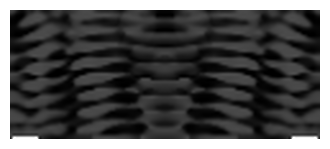

f= [0.0234564] dJ= [7.44469738e-05 8.83583822e-05 9.50699366e-05 ... 1.85928327e-03
 1.42601962e-03 1.09192954e-03]
  → Bi_idx = 0.000
Current iteration: 22
Current beta: 5.571925180803288
Starting forward run...
Starting adjoint run...
Calculating gradient...


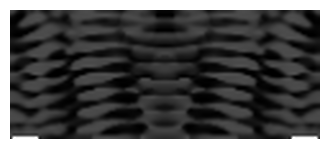

f= [0.02016756] dJ= [-0.00058846 -0.00086161 -0.00112312 ...  0.00183167  0.00082234
 -0.00010631]
  → Bi_idx = 0.000
Current iteration: 23
Current beta: 5.850521439843453
Starting forward run...
Starting adjoint run...
Calculating gradient...


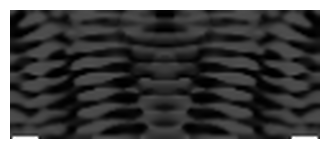

f= [0.01870315] dJ= [ 2.83845643e-05  1.79023392e-05 -2.58199417e-05 ...  1.97897190e-03
  1.18184147e-03  6.40778653e-04]
  → Bi_idx = 0.000
Current iteration: 24
Current beta: 6.143047511835626
Starting forward run...
Starting adjoint run...
Calculating gradient...


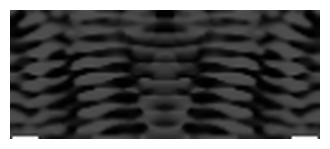

f= [0.01729513] dJ= [8.29813242e-05 1.87200722e-04 2.70829651e-04 ... 1.74618864e-03
 1.29430662e-03 1.13962662e-03]
  → Bi_idx = 0.000
Current iteration: 25
Current beta: 6.450199887427408
Starting forward run...
Starting adjoint run...
Calculating gradient...


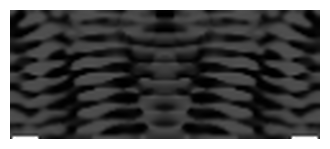

f= [0.01718287] dJ= [-0.00010035 -0.00016736 -0.00024996 ...  0.00160388  0.0013036
  0.00113029]
  → Bi_idx = 0.000
Current iteration: 26
Current beta: 6.772709881798778
Starting forward run...
Starting adjoint run...
Calculating gradient...


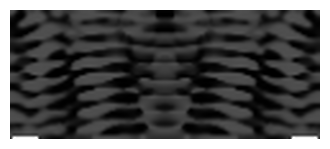

f= [0.01895068] dJ= [-0.00011802 -0.00022987 -0.00037386 ...  0.00128288  0.0011188
  0.00098109]
  → Bi_idx = 0.000
Current iteration: 27
Current beta: 7.111345375888717
Starting forward run...
Starting adjoint run...
Calculating gradient...


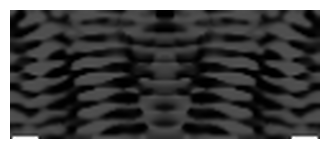

f= [0.02112372] dJ= [0.0001184  0.00017575 0.00024585 ... 0.000939   0.00083742 0.00078929]
  → Bi_idx = 0.003
Current iteration: 28
Current beta: 7.466912644683153
Starting forward run...
Starting adjoint run...
Calculating gradient...


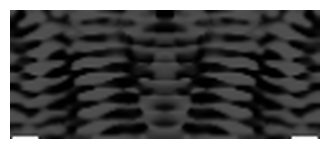

f= [0.02148273] dJ= [ 3.35646115e-05  1.61460975e-05 -1.73121570e-05 ...  9.42899188e-04
  7.28555877e-04  5.74117692e-04]
  → Bi_idx = 0.007
Current iteration: 29
Current beta: 7.840258276917311
Starting forward run...
Starting adjoint run...
Calculating gradient...


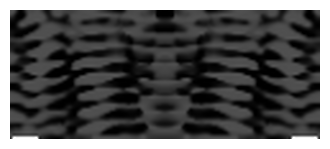

f= [0.02010182] dJ= [-0.0004181  -0.00070173 -0.00111834 ...  0.00104803  0.00067685
  0.00031453]
  → Bi_idx = 0.018
Current iteration: 30
Current beta: 8.232271190763177
Starting forward run...
Starting adjoint run...
Calculating gradient...


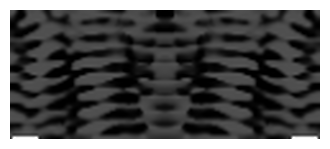

f= [0.01992721] dJ= [-0.00031853 -0.00059304 -0.00099955 ...  0.00094936  0.00063077
  0.00026671]
  → Bi_idx = 0.032
Current iteration: 31
Current beta: 8.643884750301336
Starting forward run...
Starting adjoint run...
Calculating gradient...


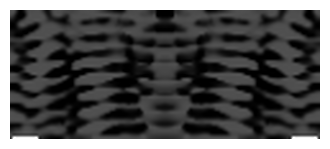

f= [0.0211416] dJ= [ 7.69657365e-05  1.24006325e-05 -8.20855216e-05 ...  7.51497538e-04
  5.66907978e-04  3.17550556e-04]
  → Bi_idx = 0.053
Current iteration: 32
Current beta: 9.076078987816404
Starting forward run...
Starting adjoint run...
Calculating gradient...


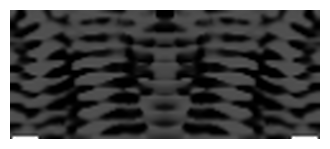

f= [0.02166953] dJ= [1.40713524e-04 1.14725062e-04 8.10752655e-05 ... 5.22484502e-04
 3.75409956e-04 1.06571240e-04]
  → Bi_idx = 0.073
Current iteration: 33
Current beta: 9.529882937207224
Starting forward run...
Starting adjoint run...
Calculating gradient...


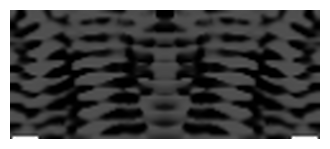

f= [0.01821409] dJ= [ 6.62211605e-05  2.01884029e-05 -4.00587662e-05 ...  1.20724611e-04
  1.87001221e-04 -1.32720104e-04]
  → Bi_idx = 0.099
Current iteration: 34
Current beta: 10.006377084067585
Starting forward run...
Starting adjoint run...
Calculating gradient...


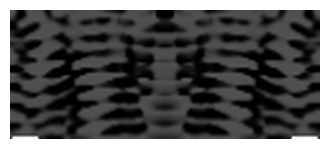

f= [0.02072902] dJ= [ 9.10899746e-05  1.24473591e-04  1.74481018e-04 ... -1.06918897e-04
  6.48928241e-05 -9.41948414e-05]
  → Bi_idx = 0.125
Current iteration: 35
Current beta: 10.506695938270965
Starting forward run...
Starting adjoint run...
Calculating gradient...


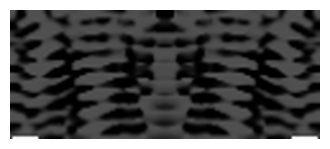

f= [0.02063941] dJ= [ 1.74395504e-05  3.08019427e-06 -1.78394390e-05 ... -1.04589058e-04
 -8.26393846e-05 -3.78267666e-04]
  → Bi_idx = 0.154
Current iteration: 36
Current beta: 11.032030735184515
Starting forward run...
Starting adjoint run...
Calculating gradient...


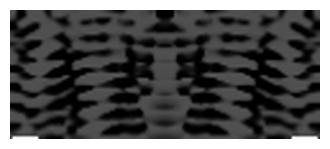

f= [0.01795038] dJ= [-4.65560960e-05 -8.80439185e-05 -1.46062838e-04 ...  1.15935005e-05
  1.08247527e-04 -2.43439862e-04]
  → Bi_idx = 0.184
Current iteration: 37
Current beta: 11.583632271943742
Starting forward run...
Starting adjoint run...
Calculating gradient...


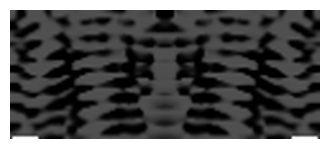

f= [0.0185097] dJ= [ 8.65080775e-07 -7.37493116e-06 -1.67804814e-05 ...  1.40536919e-04
  3.90121643e-04  3.77787657e-04]
  → Bi_idx = 0.214
Current iteration: 38
Current beta: 12.16281388554093
Starting forward run...
Starting adjoint run...
Calculating gradient...


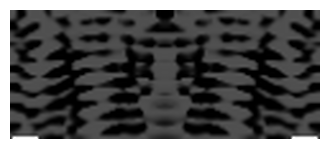

f= [0.01979966] dJ= [1.72812386e-05 2.36250271e-05 3.40440930e-05 ... 3.45615294e-04
 4.23383525e-04 4.80380425e-04]
  → Bi_idx = 0.254
Current iteration: 39
Current beta: 12.770954579817976
Starting forward run...
Starting adjoint run...
Calculating gradient...


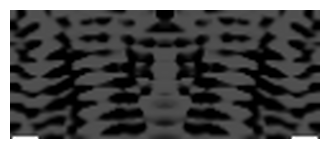

f= [0.02025403] dJ= [ 8.37226969e-06  4.93117949e-06 -2.19418902e-06 ...  4.52239706e-04
  6.39509395e-04  8.94128335e-04]
  → Bi_idx = 0.285
Current iteration: 40
Current beta: 13.409502308808875
Starting forward run...
Starting adjoint run...
Calculating gradient...


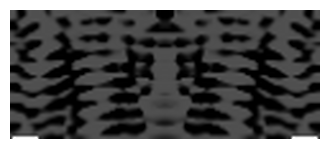

f= [0.02147964] dJ= [-2.38453818e-06 -7.92721239e-06 -1.67684189e-05 ...  2.86367555e-04
  7.89957498e-04  1.61795874e-03]
  → Bi_idx = 0.313
Current iteration: 41
Current beta: 14.07997742424932
Starting forward run...
Starting adjoint run...
Calculating gradient...


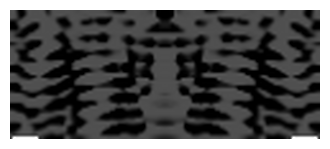

f= [0.02177756] dJ= [ 3.12025297e-06  1.35795153e-05  3.21378423e-05 ... -2.94005988e-04
  1.30289677e-04  1.00606365e-03]
  → Bi_idx = 0.339
Current iteration: 42
Current beta: 14.783976295461786
Starting forward run...
Starting adjoint run...
Calculating gradient...


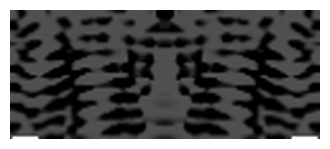

f= [0.02075406] dJ= [ 1.54113635e-05  4.75052063e-06 -2.04904396e-06 ... -1.43079921e-04
  2.05744525e-04  8.84932675e-04]
  → Bi_idx = 0.379
Current iteration: 43
Current beta: 15.523175110234876
Starting forward run...
Starting adjoint run...
Calculating gradient...


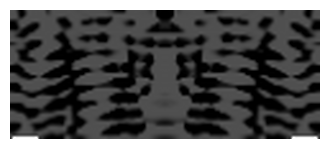

f= [0.01823429] dJ= [-0.00016761 -0.00035221 -0.00061422 ... -0.00011828  0.00016764
  0.00093348]
  → Bi_idx = 0.413
Current iteration: 44
Current beta: 16.299333865746622
Starting forward run...
Starting adjoint run...
Calculating gradient...


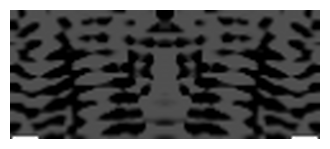

f= [0.01737223] dJ= [-3.94762179e-04 -6.91198700e-04 -1.11981719e-03 ... -1.64720339e-05
 -1.17036079e-04  4.38792258e-05]
  → Bi_idx = 0.442
Current iteration: 45
Current beta: 17.114300559033953
Starting forward run...
Starting adjoint run...
Calculating gradient...


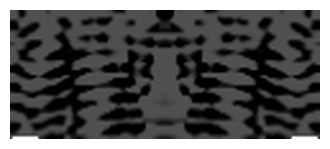

f= [0.01904748] dJ= [-0.00025975 -0.00051066 -0.00086192 ...  0.00035491  0.00042995
  0.00097733]
  → Bi_idx = 0.466
Current iteration: 46
Current beta: 17.970015586985653
Starting forward run...
Starting adjoint run...
Calculating gradient...


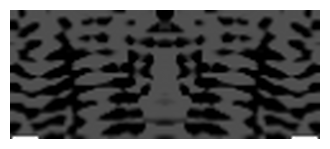

f= [0.02109308] dJ= [-1.60544962e-05 -9.49716238e-05 -2.05710806e-04 ...  4.02103912e-04
  6.19415140e-04  1.67686714e-03]
  → Bi_idx = 0.491
Current iteration: 47
Current beta: 18.868516366334937
Starting forward run...
Starting adjoint run...
Calculating gradient...


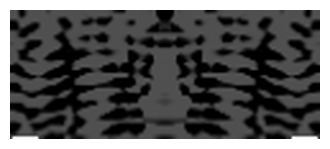

f= [0.02191235] dJ= [ 2.53469634e-05  4.13347371e-06 -2.55427121e-05 ...  2.95264908e-04
  3.72149703e-04  1.22363688e-03]
  → Bi_idx = 0.515
Current iteration: 48
Current beta: 19.811942184651684
Starting forward run...
Starting adjoint run...
Calculating gradient...


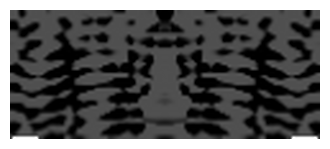

f= [0.0222456] dJ= [ 4.23331904e-06 -1.11742307e-05 -2.56441037e-05 ...  3.53948639e-04
  2.55276948e-04  4.01537889e-04]
  → Bi_idx = 0.537
Current iteration: 49
Current beta: 20.80253929388427
Starting forward run...
Starting adjoint run...
Calculating gradient...


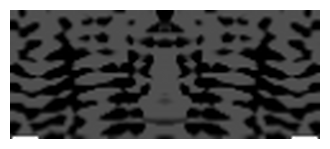

f= [0.0228072] dJ= [-1.01920923e-06 -4.09465878e-06 -1.06689056e-06 ...  4.19584259e-04
  3.19242284e-04  3.51302382e-04]
  → Bi_idx = 0.558
Current iteration: 50
Current beta: 21.842666258578483
Starting forward run...
Starting adjoint run...
Calculating gradient...


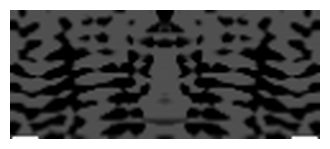

f= [0.02250177] dJ= [-1.52402163e-05 -2.06966306e-05 -1.67821562e-05 ...  4.36844794e-04
  4.28362618e-04  7.04205454e-04]
  → Bi_idx = 0.578
Current iteration: 51
Current beta: 22.93479957150741
Starting forward run...
Starting adjoint run...
Calculating gradient...


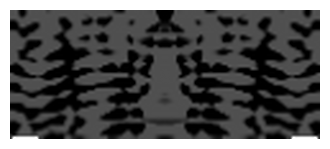

f= [0.02181009] dJ= [-6.51925842e-07  9.91379445e-06  3.42650745e-05 ...  4.46212665e-04
  4.42508245e-04  6.44983424e-04]
  → Bi_idx = 0.596
Current iteration: 52
Current beta: 24.08153955008278
Starting forward run...
Starting adjoint run...
Calculating gradient...


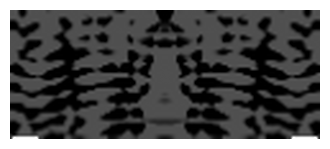

f= [0.02105017] dJ= [-1.77671129e-05 -2.90341021e-05 -3.81071450e-05 ...  5.35287204e-04
  5.14375309e-04  7.52513918e-04]
  → Bi_idx = 0.622
Current iteration: 53
Current beta: 25.28561652758692
Starting forward run...
Starting adjoint run...
Calculating gradient...


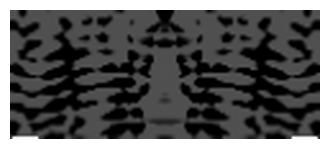

f= [0.02171816] dJ= [-2.71846197e-05 -2.35428460e-05 -2.35645963e-05 ...  4.84227082e-04
  7.39380126e-04  1.81946089e-03]
  → Bi_idx = 0.637
Current iteration: 54
Current beta: 26.54989735396627
Starting forward run...
Starting adjoint run...
Calculating gradient...


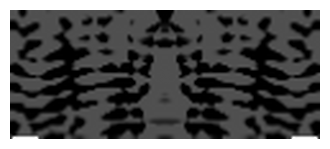

f= [0.02221543] dJ= [-4.16103687e-05 -5.22926575e-05 -4.99742971e-05 ...  3.88079371e-04
  7.69228678e-04  1.54688560e-03]
  → Bi_idx = 0.651
Current iteration: 55
Current beta: 27.877392221664582
Starting forward run...
Starting adjoint run...
Calculating gradient...


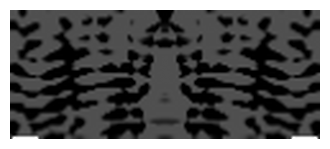

f= [0.02257879] dJ= [-1.65713390e-05 -1.20813326e-05  1.02447806e-05 ...  4.48887800e-04
  9.09319853e-04  1.63050669e-03]
  → Bi_idx = 0.670
Current iteration: 56
Current beta: 29.27126183274781
Starting forward run...
Starting adjoint run...
Calculating gradient...


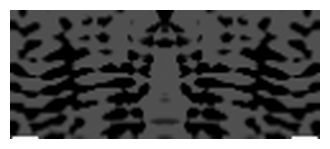

f= [0.02322509] dJ= [1.01122522e-06 5.35601799e-06 9.00808329e-06 ... 8.05884535e-04
 1.14947867e-03 1.86509253e-03]
  → Bi_idx = 0.690
Current iteration: 57
Current beta: 30.734824924385205
Starting forward run...
Starting adjoint run...
Calculating gradient...


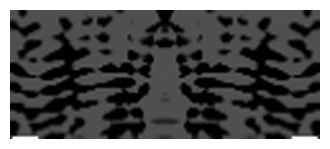

f= [0.02347309] dJ= [1.55836641e-05 1.70005892e-05 2.18725405e-06 ... 1.02307449e-03
 1.31720000e-03 1.97112781e-03]
  → Bi_idx = 0.705
Current iteration: 58
Current beta: 32.271566170604466
Starting forward run...
Starting adjoint run...
Calculating gradient...


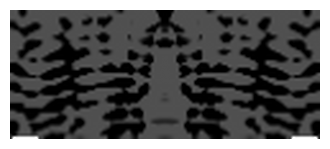

f= [0.02320822] dJ= [ 2.08385260e-05  5.12546312e-06 -3.23425449e-05 ...  1.12472799e-03
  1.48585644e-03  2.27757240e-03]
  → Bi_idx = 0.720
Current iteration: 59
Current beta: 33.88514447913469
Starting forward run...
Starting adjoint run...
Calculating gradient...


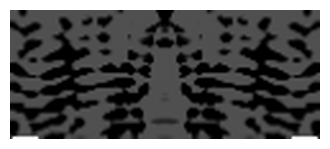

f= [0.02273266] dJ= [ 2.65623483e-05  8.96212632e-06 -2.46537277e-05 ...  1.14645020e-03
  1.60919491e-03  2.64222518e-03]
  → Bi_idx = 0.735
Current iteration: 60
Current beta: 35.57940170309142
Starting forward run...
Starting adjoint run...
Calculating gradient...


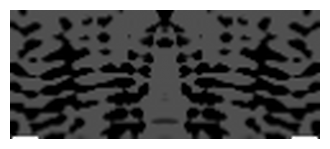

f= [0.02208429] dJ= [ 2.11906005e-05  8.48425666e-06 -1.36969782e-05 ...  1.15809118e-03
  1.69348166e-03  2.94282874e-03]
  → Bi_idx = 0.750
Current iteration: 61
Current beta: 37.358371788246
Starting forward run...
Starting adjoint run...
Calculating gradient...


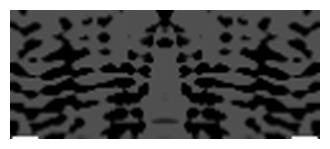

f= [0.02198509] dJ= [ 8.64575965e-06 -3.17788364e-06 -2.16273182e-05 ...  1.15004648e-03
  1.73652867e-03  3.13839404e-03]
  → Bi_idx = 0.764
Current iteration: 62
Current beta: 39.226290377658295
Starting forward run...
Starting adjoint run...
Calculating gradient...


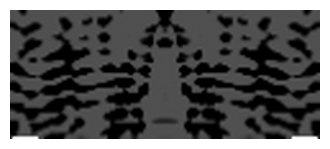

f= [0.02246559] dJ= [ 9.24267702e-06  3.57006410e-06 -7.93193370e-06 ...  1.04430375e-03
  1.67565097e-03  3.16967074e-03]
  → Bi_idx = 1.000
Binarization threshold reached. Final binary mapping…
Current iteration: 63
Current beta: inf
Starting forward run...


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/autograd/tracer.py:54: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:124: RuntimeWarning: divide by zero encountered in divide
  lambda ans, x, y: unbroadcast_f(x, lambda g: g / y),
/tmp/ipykernel_11804/2317079864.py:35: RuntimeWarning: invalid value encountered in divide
  update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate


Starting adjoint run...
Calculating gradient...


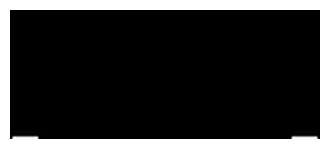

f= [0.00049996] dJ= [-1.47542777e-05 -1.93375434e-05 -1.25738865e-05 ... -1.24129221e-05
  1.59834423e-05  4.80911548e-05]


In [347]:
cur_beta=2
n=Nx*Ny
x=np.ones(n)*0.5
x_history = []

Max_iter = 100
while cur_iter[0] < Max_iter:
    # 1) 한 번 실행
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)
    # 2) 전체 Geo (=mapping 결과) 가져오기
    Geo = mapping(x, cur_beta, eta_i)  # shape = (Nx*Ny,)

    # 3) binarization index 계산
    Bi_idx = np.sum(np.where(((1e-3 < Geo) & (Geo < (1 - 1e-3))), 0, 1)) / Geo.size
    print(f"  → Bi_idx = {Bi_idx:.3f}")

    # 4) 임계치 도달 시 마지막 binary 실행 후 루프 종료
    if Bi_idx > 0.95:
        print("Binarization threshold reached. Final binary mapping…")
        # beta = inf으로 하여 완전 0/1 투영
        x, adam_m, adam_v, _ = f(x, eta_i, np.inf)
        break

In [230]:
total_iter = 200
cur_beta=2
n=Nx*Ny
x=np.ones(n)*0.5
x_history = []

mp.verbosity(0)
for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)
    x_history.append(x.copy())

Current iteration: 201
Current beta: 2
Starting forward run...


KeyboardInterrupt: 

0.4566201664378916

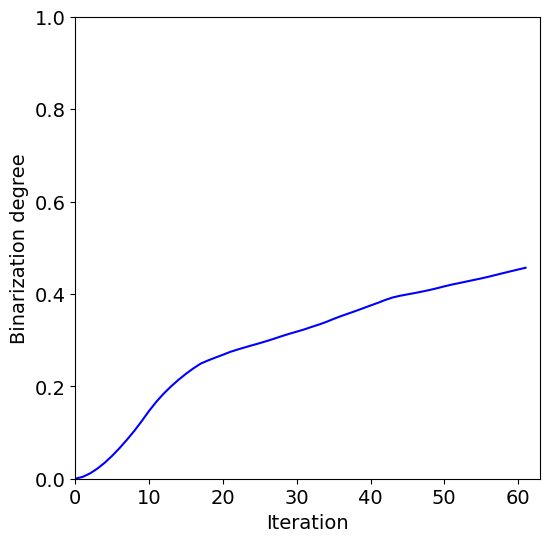

In [349]:
plt.figure(figsize = (6,6))
plt.plot(binarization_history, 'b-')
plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('Binarization degree',fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlim(0, np.array(cur_iter))
plt.ylim(0,1)

max(binarization_history)

In [ ]:
foms = np.real(evaluation_history)
best_idx = np.argmax(foms)

init_idx = 4  # 0-based index → 5번째
if len(foms) > init_idx:
    init_fom    = foms[init_idx]
    init_beta   = beta_history[init_idx]
    init_design = x_history[init_idx]
    print(f"[Iteration 5] FoM = {init_fom:.4e}, β = {init_beta:.4f}, 디자인 (첫 10개) = {init_design[:10]} …")
else:
    print(f"Iteration 수({len(foms)})가 5보다 작아 5번째 정보가 없습니다.")

# --- 2) FoM 최대일 때 정보 ---
best_fom    = foms[best_idx]
best_beta   = beta_history[best_idx]
best_design = x_history[best_idx]
print(f"[Best Iteration {best_idx+1}] FoM = {best_fom:.4e}, β = {best_beta:.4f}, 디자인 (첫 10개) = {best_design[:10]} …")

# --- 3) 마지막 iteration 정보 ---
last_idx    = len(foms) - 1
last_fom    = foms[last_idx]
last_beta   = beta_history[last_idx]
last_design = x_history[last_idx]
print(f"[Last Iteration {last_idx+1}] FoM = {last_fom:.4e}, β = {last_beta:.4f}, 디자인 (첫 10개) = {last_design[:10]} …")


[Iteration 5] FoM = 7.8162e-03, β = 1.0255, 디자인 (첫 10개) = [0.48493738 0.48495314 0.48497731 0.48505997 0.50241746 0.48492165
 0.4849228  0.48493061 0.48493777 0.48494501] …
[Best Iteration 49] FoM = 2.9363e-01, β = 1.3142, 디자인 (첫 10개) = [0.74421615 0.73063787 0.707305   0.64868425 0.63900181 0.66814158
 0.73739587 0.76567029 0.77633327 0.76907926] …
[Last Iteration 100] FoM = 2.6264e-01, β = 1.8524, 디자인 (첫 10개) = [1.         1.         1.         0.84030487 0.52261599 0.42578589
 0.70431416 0.92816575 1.         1.        ] …


# FOM이 떨어지는 지점에서 beta 값이 수정되는건지?
# Multi layer 

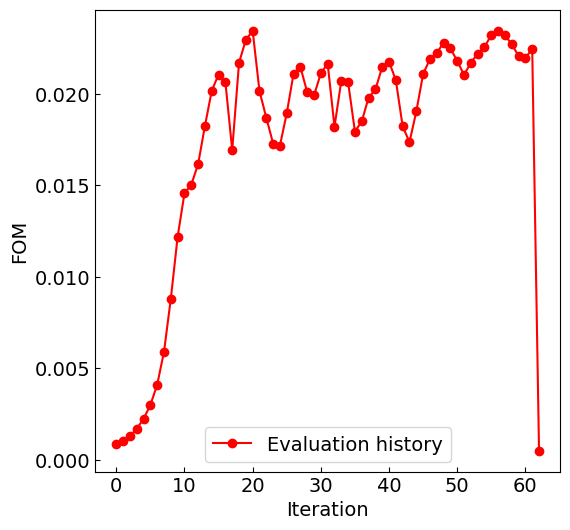

In [350]:
plt.figure(figsize = (6,6))

plt.plot(evaluation_history, 'or-',   label='Evaluation history',)

plt.xlabel('Iteration',fontsize = 14)
plt.ylabel('FOM',fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# plt.title('Optimization', fontsize = 16)
plt.tick_params(direction = 'in')

plt.legend( fontsize = 14,)

plt.show()

In [ ]:
# np.savetxt("init_design.txt", x_history[init_idx])
# np.savetxt("best_design.txt", x_history[best_idx])
# np.savetxt("last_design.txt", x_history[last_idx])

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_mean_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_1lambda_pos_new_objf.txt", design_variables.weights)

In [ ]:
# np.savetxt("adam_weights_2lambda_pos.txt", design_variables.weights)

In [10]:
import numpy as np

data = np.loadtxt('adam_weights_1lambda_pos_new_objf.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])
# data


Loaded array shape: (6171,)


In [405]:
data_init = np.loadtxt('init_design.txt')
data_best = np.loadtxt('best_design.txt')
data_last = np.loadtxt('last_design.txt')

# opt.update_design([data_init])
# opt.update_design([data_best])
opt.update_design([data_last])

In [ ]:
# np.savetxt("adam_iter400.txt", design_variables.weights)

In [267]:
iter_400 = np.loadtxt('adam_iter400.txt')
opt.update_design([iter_400])

(-1.2, 1.2, 1.0154545454545456, 2.0154545454545456)

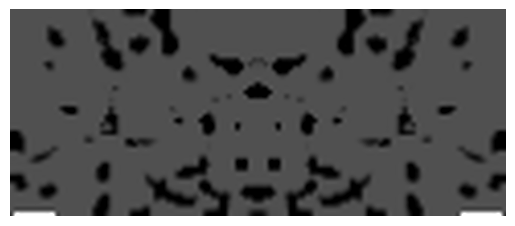

In [269]:
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    show_sources=False,
    show_monitors=False,
    show_boundary_layers=False,
)
plt.axis(False)

In [271]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
                # weight=-1
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D(True)


AttributeError: 'bool' object has no attribute 'imshow'

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


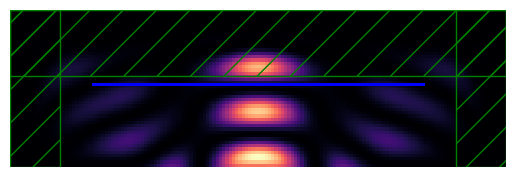

In [272]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10/df, mp.Ez, sources.center, 1e-3))

opt.sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':0.5}
)
plt.axis(False)
plt.show()

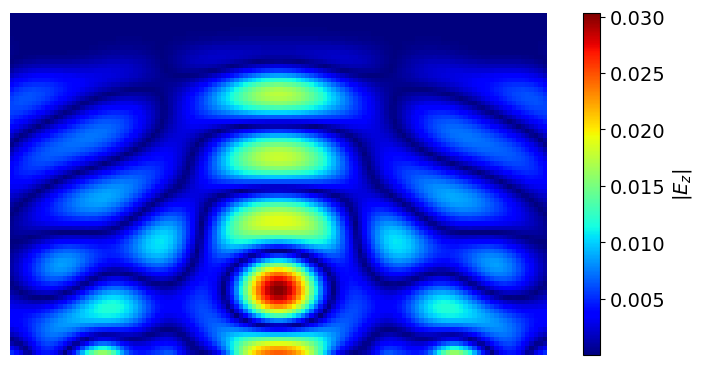

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt.sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
plt.tight_layout()
plt.axis('off')
plt.show()

<Axes: xlabel='X', ylabel='Y'>

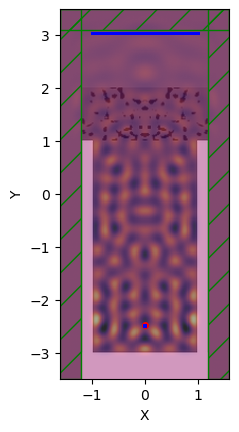

In [274]:
opt.sim.plot2D(fields = mp.Ez,
               show_sources=True,
    show_monitors=True,
    show_boundary_layers=True,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 0.5,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

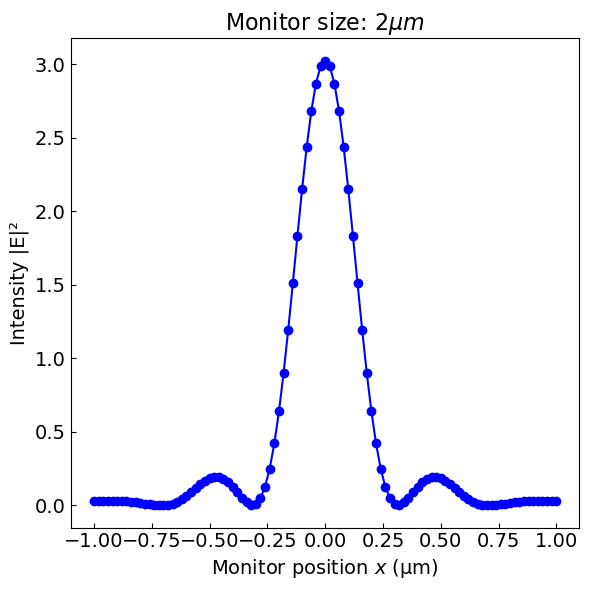

In [275]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

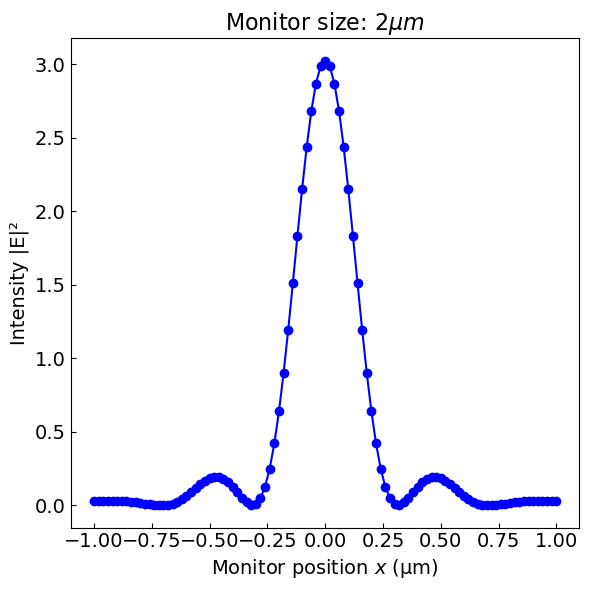

In [276]:
external_field_array = (sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [277]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100

print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

Input flux : 0.7905876198702897
Output flux : 0.8443105956162665
EQE(%) : 106.79532216236716 %
